<a href="https://colab.research.google.com/github/326eunjin/ai-team_project/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical,plot_model

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
# Visualize용 y_test 기존 데이터 형태 저장
y_test_origin = y_test

#정규화 및 one-hot encoding
x_train = x_train.astype('float32') / 255.0
y_train = to_categorical(y_train)
x_test = x_test.astype('float32') / 255.0
y_test = to_categorical(y_test)

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
# Model modeling
model = tf.keras.models.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(512, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    GlobalAveragePooling2D(),
    Dense(10, activation='softmax')
])

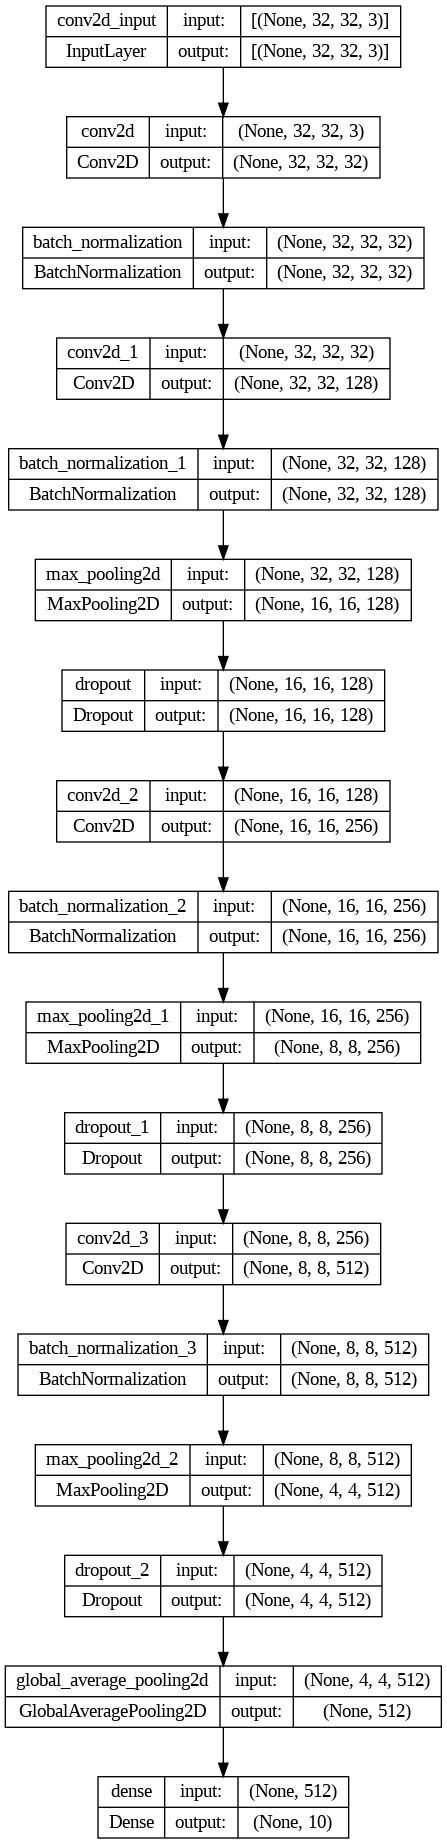

In [4]:
# model 시각화
plot_model(model, show_shapes=True)

In [5]:
# Model Compiling
batch_size=64
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Logging
log_dir = './logs/tensorflow'
tensorboard_cb=keras.callbacks.TensorBoard(log_dir)

epochs 0:
782/782 [==============================] - 34s 26ms/step - loss: 1.2448 - accuracy: 0.5581
epochs 1:
782/782 [==============================] - 20s 26ms/step - loss: 0.8155 - accuracy: 0.7167
epochs 2:
782/782 [==============================] - 21s 27ms/step - loss: 0.6465 - accuracy: 0.7748
epochs 3:
782/782 [==============================] - 20s 26ms/step - loss: 0.5472 - accuracy: 0.8114
epochs 4:
782/782 [==============================] - 20s 26ms/step - loss: 0.4776 - accuracy: 0.8341
epochs 5:
782/782 [==============================] - 20s 26ms/step - loss: 0.4187 - accuracy: 0.8530
epochs 6:
782/782 [==============================] - 22s 29ms/step - loss: 0.3720 - accuracy: 0.8704


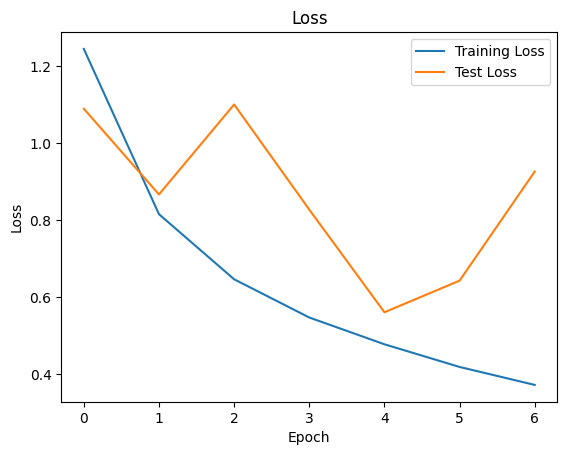

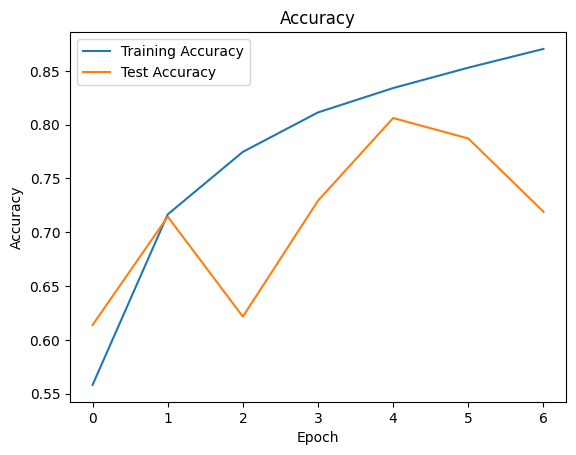

In [6]:
# Store losses & accs
train_loss = []
train_acc = []
test_loss = []
test_acc = []

# Model Training
epochs = 7

for _ in range(epochs):
  print(f"epochs {_}:")
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, callbacks=[tensorboard_cb])
  train_loss.append(history.history['loss'][0])
  train_acc.append(history.history['accuracy'][0])
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  test_loss.append(loss)
  test_acc.append(acc)

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [7]:
# Visualize를 위한 차원 축소
pca = PCA(n_components=3)

In [8]:
## Visualization of intermediate model evaluation

# Extract intermediate model
intermediate_model = Sequential(model.layers[:-1])
intermediate_features = intermediate_model.predict(x_test)
reduced_intermediate_features = pca.fit_transform(intermediate_features)

scatter_trace = go.Scatter3d(
    x=reduced_intermediate_features[:, 0],
    y=reduced_intermediate_features[:, 1],
    z=reduced_intermediate_features[:, 2],
    mode='markers',
    marker=dict(
        color=y_test_origin.flatten(),
        colorscale='Viridis',
        size=3,
        opacity=0.8
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')),
    title='Visualization of intermediate model evaluation - categorical crossentropy'
)

fig = go.Figure(data=[scatter_trace], layout=layout)
fig.update_layout(width=800, height=800)
fig.show()


313/313 [==============================] - 1s 3ms/step


In [9]:
## Visualization of model evaluation

test_features = model.predict(x_test)
reduced_test_features = pca.fit_transform(test_features)

scatter_trace = go.Scatter3d(
    x=reduced_test_features[:, 0],
    y=reduced_test_features[:, 1],
    z=reduced_test_features[:, 2],
    mode='markers',
    marker=dict(
        color=y_test_origin.flatten(),
        colorscale='Viridis',
        size=2,
        opacity=0.8
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')),
    title='Visualization of model evaluation'
)

fig = go.Figure(data=[scatter_trace], layout=layout)
fig.update_layout(width=800, height=800)
fig.show()


313/313 [==============================] - 1s 4ms/step


In [10]:
def generate_cam(model, image, index):
    last_conv_layer = model.get_layer('conv2d_3')

    # 기존 모델에서 마지막 Convolution Layer의 결과값 추출하여 출력
    cam_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # 이미지 전처리
    img = np.expand_dims(image, axis=0)
    img = img.astype('float32') / 255.0

    features, predictions = cam_model.predict(img)
    label = np.argmax(predictions[0])
    
    # 각 특징맵에 가중치 행렬곱 연산
    cam = np.dot(features[0], model.get_layer('dense').get_weights()[0][:, label])

    # CAM 이미지와 CIFAR-10 이미지의 크기 매칭 및 정규화
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    # Convert the CAM to a heatmap using a color map
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Apply the heatmap to the input image
    cam_image = heatmap * 0.5 + image * 255 * 0.5
    cam_image = np.uint8(cam_image)

    return cam_image


In [11]:
features = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


1/1 [==============================] - 0s 214ms/step


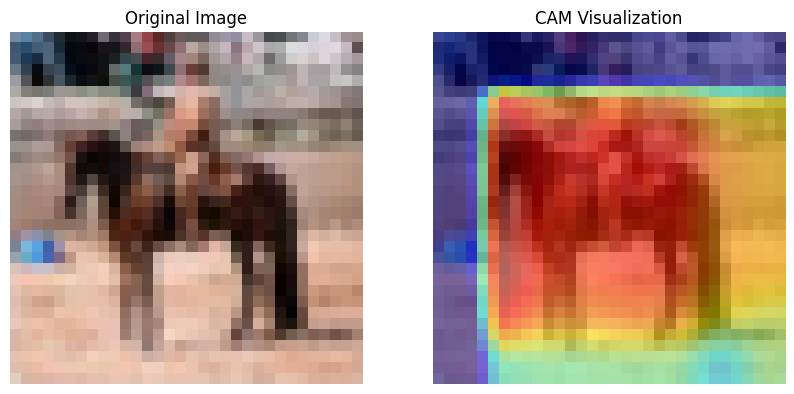

prediction:	horse
answer:		horse
1/1 [==============================] - 0s 121ms/step


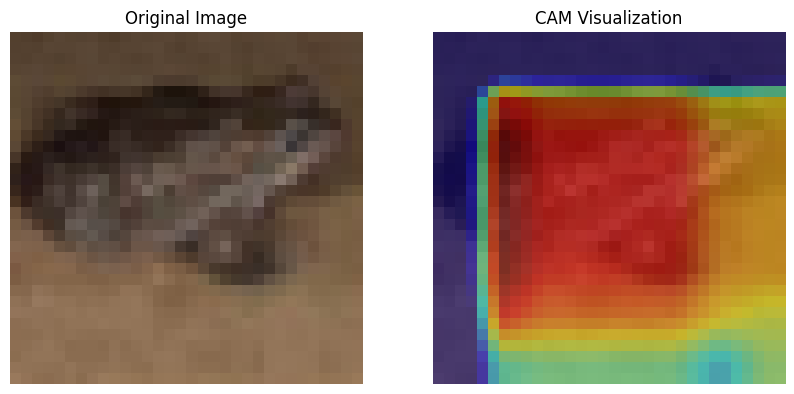

prediction:	cat
answer:		frog
1/1 [==============================] - 0s 110ms/step


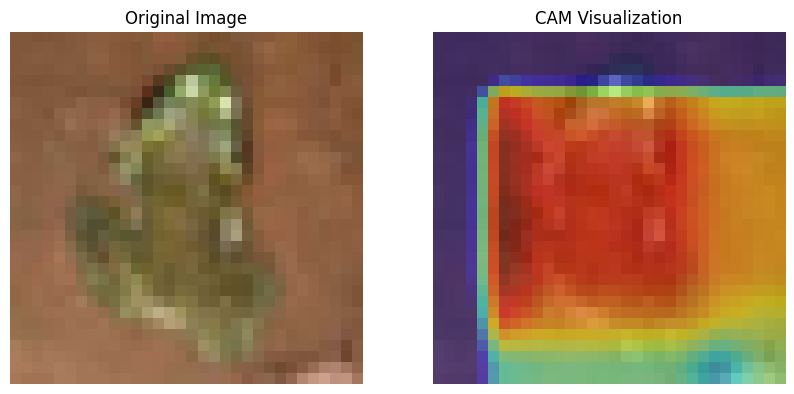

prediction:	cat
answer:		frog
1/1 [==============================] - 0s 121ms/step


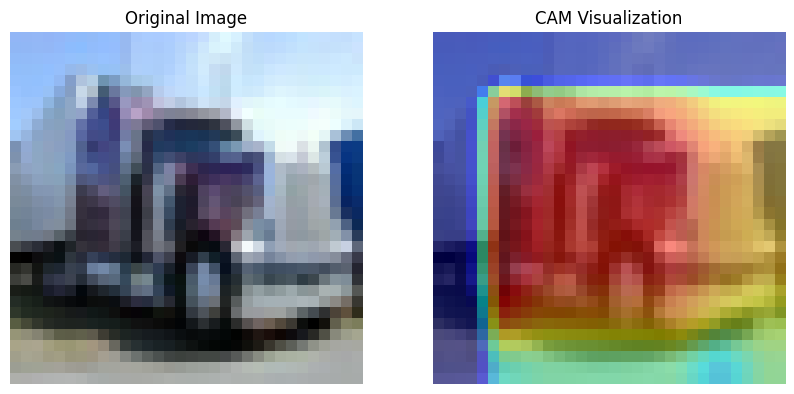

prediction:	truck
answer:		truck
1/1 [==============================] - 0s 121ms/step


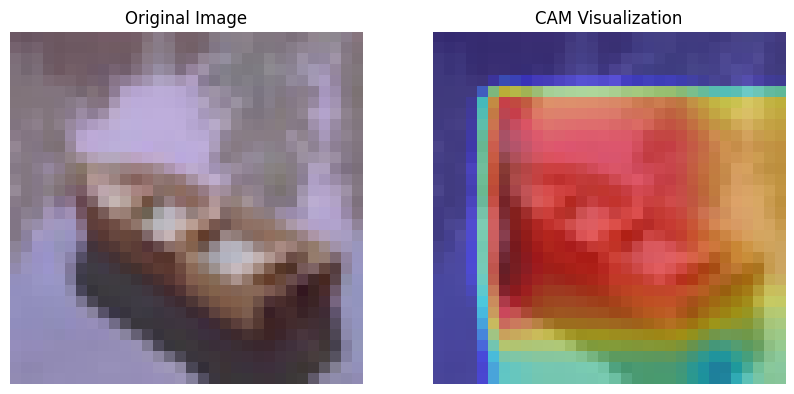

prediction:	cat
answer:		ship
1/1 [==============================] - 0s 118ms/step


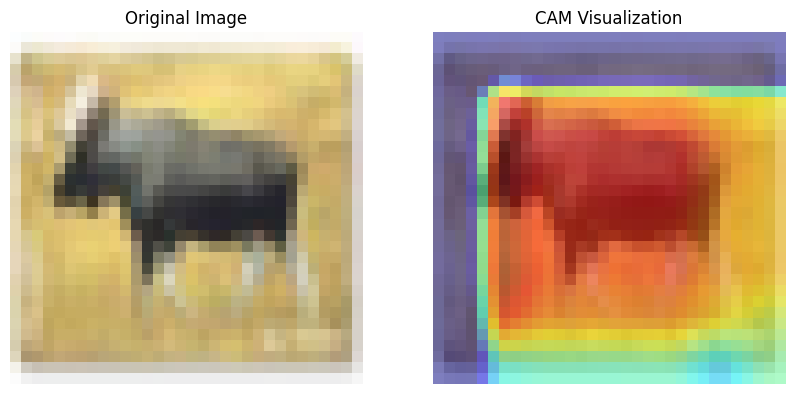

prediction:	bird
answer:		deer
1/1 [==============================] - 0s 115ms/step


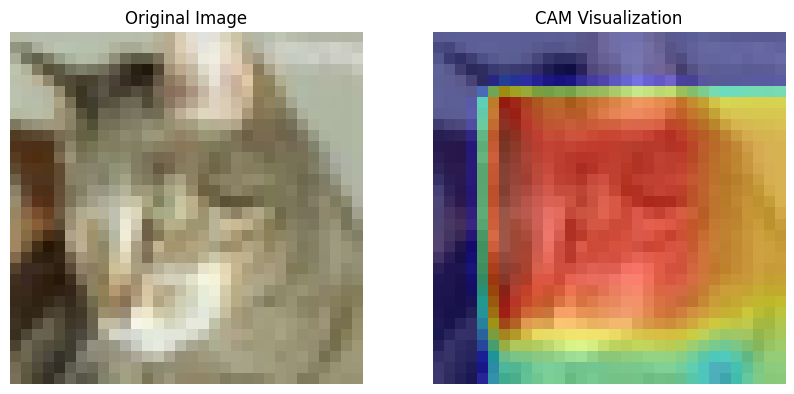

prediction:	cat
answer:		cat
1/1 [==============================] - 0s 118ms/step


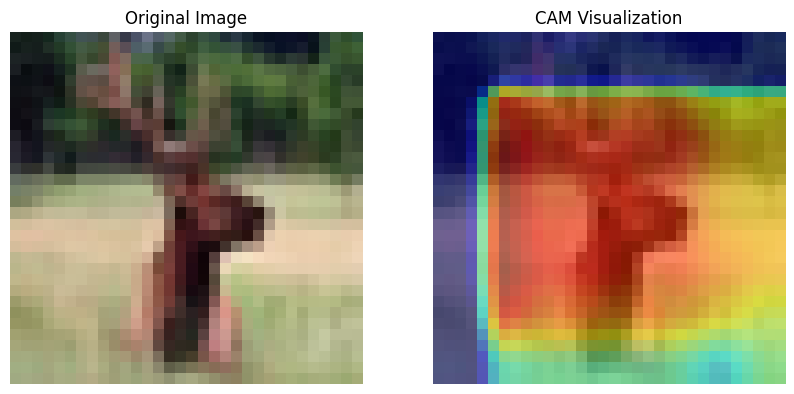

prediction:	deer
answer:		deer
1/1 [==============================] - 0s 115ms/step


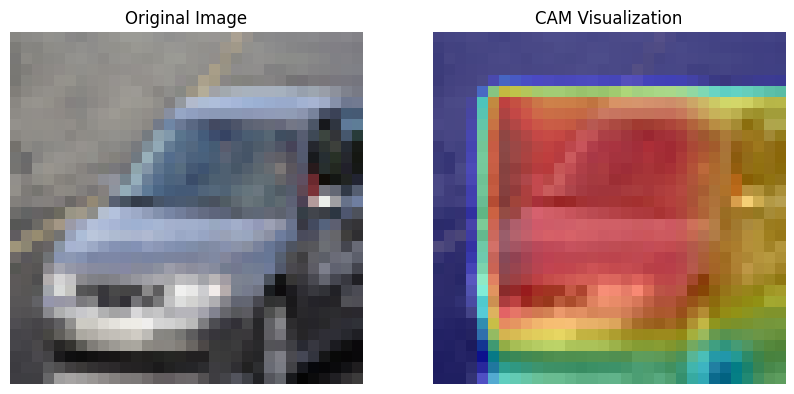

prediction:	automobile
answer:		automobile
1/1 [==============================] - 0s 128ms/step


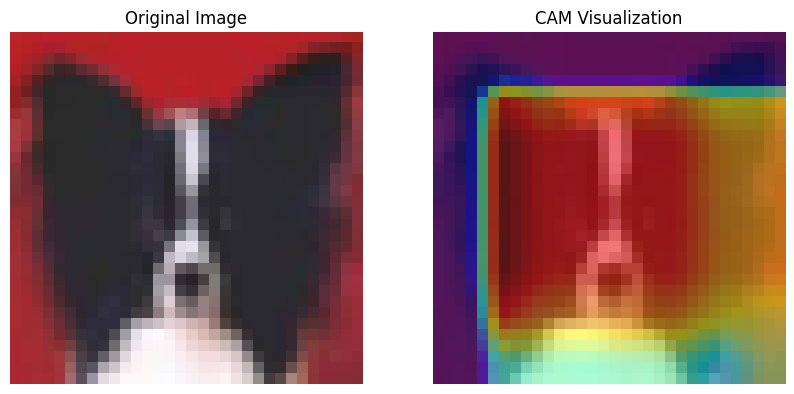

prediction:	dog
answer:		dog
1/1 [==============================] - 0s 123ms/step


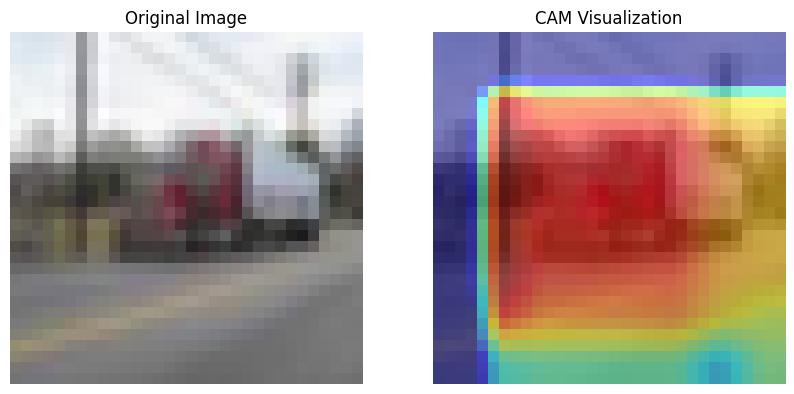

prediction:	truck
answer:		truck
1/1 [==============================] - 0s 123ms/step


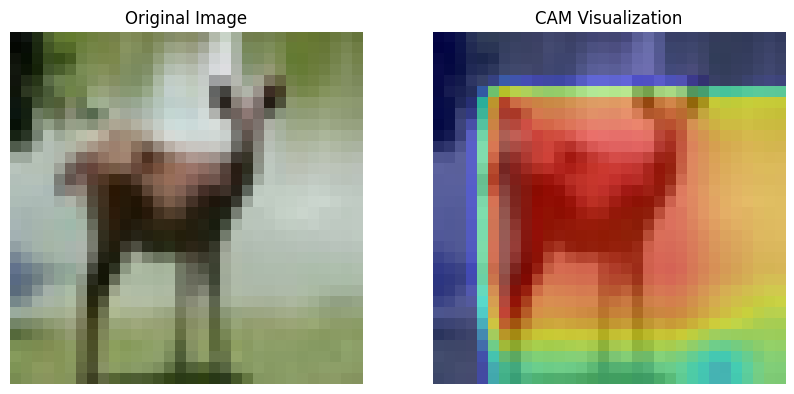

prediction:	bird
answer:		deer
1/1 [==============================] - 0s 127ms/step


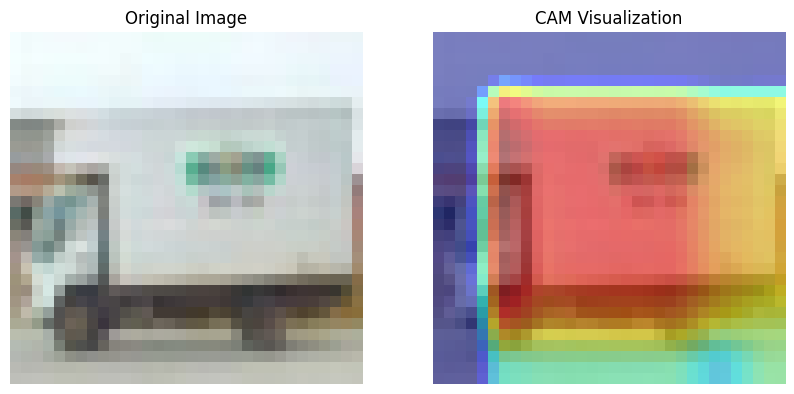

prediction:	truck
answer:		truck
1/1 [==============================] - 0s 121ms/step


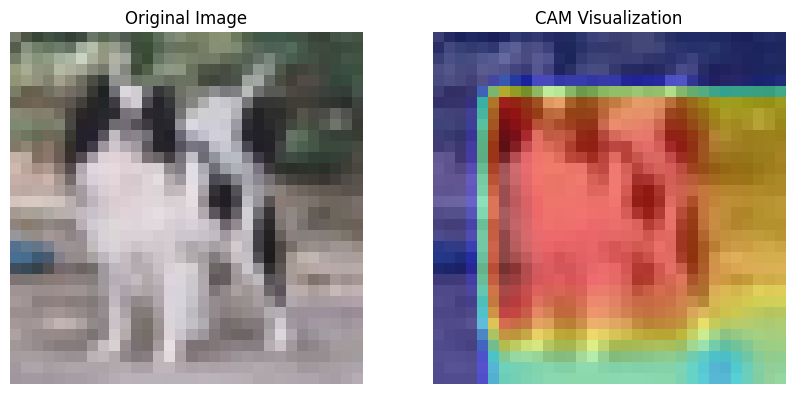

prediction:	dog
answer:		dog
1/1 [==============================] - 0s 124ms/step


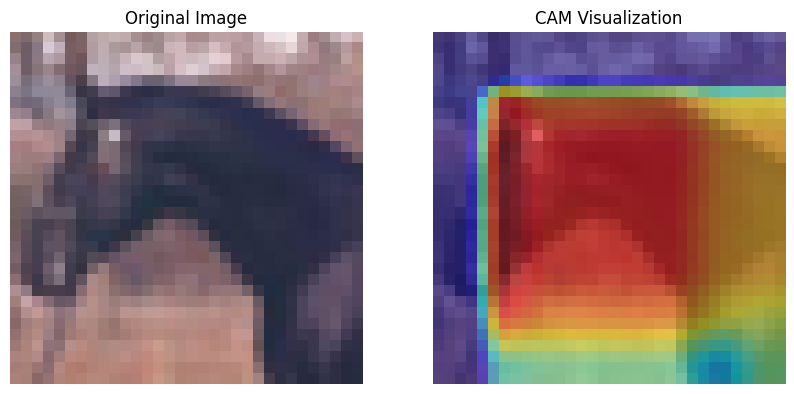

prediction:	cat
answer:		horse


In [12]:
category = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Select test image
for _ in range(15):
  index = np.random.randint(len(x_test))
  image = x_test[index]

  # Generate the CAM visualization
  cam_image = generate_cam(model, image, index)

  # Plot the original image and the CAM visualization
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.imshow(image)
  ax1.axis('off')
  ax1.set_title('Original Image')
  ax2.imshow(cam_image)
  ax2.axis('off')
  ax2.set_title('CAM Visualization')
  plt.show()
  print(f"prediction:\t{category[np.argmax(features[index])]}")
  print(f"answer:\t\t{category[np.argmax(y_test[index])]}")

In [13]:
def get_kmeans_loss():
  features = model.predict(x_train)
  # Apply K-means clustering for manifold space learning and design loss function
  kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
  kmeans.fit(features)
  kmeans_labels = kmeans.labels_

  # Calculate centroids manually
  centroids = []
  for i in range(kmeans.n_clusters):
      cluster_points = features[kmeans_labels == i]
      centroid = np.mean(cluster_points, axis=0)
      centroids.append(centroid)
  kmeans_loss = [0 for _ in range(10)]
  for i in range(len(y_train)):
    min = float('INF')
    for j in range(10):
      tmp = np.linalg.norm(y_train[i] - centroids[j], 2)
      min = tmp if min > tmp else min
    kmeans_loss[np.argmax(y_train[i])] += min
  return kmeans_loss

In [14]:
tf.config.run_functions_eagerly(True)

# Vol.1 Euclidean distance
# 최적의 알고리즘으로 선택
# kmeans_loss 추가 적용
def my_loss1(label, predict):
  np_label = np.array(label)
  loss_table = [kmeans_loss[np.argmax(np_label[i])] for i in range(len(np_label))]
  loss = tf.norm(label-predict,2) * loss_table
  return loss


# Vol.2 Cosine similarity
def my_loss2(label, predict):
  cosine_similarity = tf.tensordot(label, tf.transpose(predict),axes=1)/(tf.norm(label,2)*tf.norm(predict,2))
  loss = 1 - cosine_similarity
  return loss * 100

# Vol.3 Manhattan distance
def my_loss3(label, predict):
  loss = tf.norm(label - predict,1)
  return loss

In [15]:
batch_size=64
model.compile(optimizer='adam',
              loss=my_loss1,
              metrics=['accuracy'])

In [16]:
# Store losses & accs
train_loss = []
train_acc = []
test_loss = []
test_acc = []

# Model Training
epochs = 3
for _ in range(epochs):
  print(f"epochs {_}:")
  kmeans_loss = get_kmeans_loss()
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=2, callbacks=[tensorboard_cb], verbose=0)
  train_loss.append(history.history['loss'][0])
  train_acc.append(history.history['accuracy'][0])
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  test_loss.append(loss)
  test_acc.append(acc)

epochs 0:


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



1563/1563 [==============================] - 20s 13ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



epochs 1:
1563/1563 [==============================] - 20s 13ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



epochs 2:
1563/1563 [==============================] - 19s 12ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



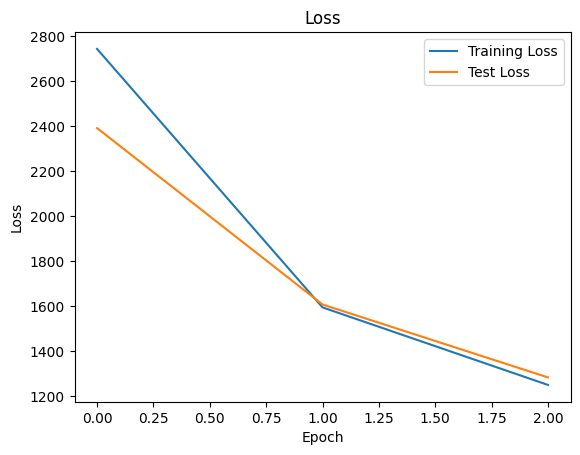

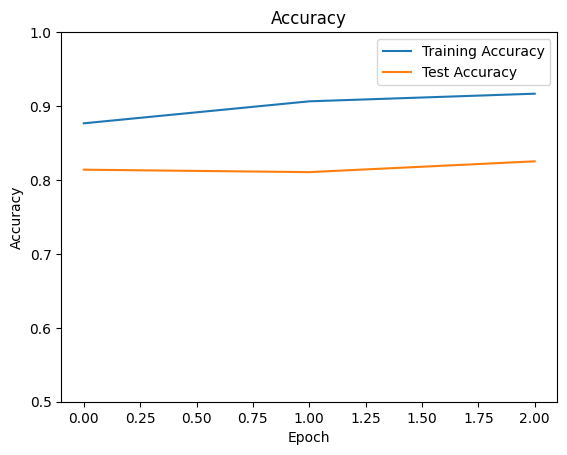

In [17]:
# y-axis ticks
y = [0.5+0.1*i for i in range(0, 6)]

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks(y)
plt.legend()
plt.show()

In [18]:
## Visualization of model evaluation

# Apply PCA for dimensionality reduction of test features
test_features = model.predict(x_test)
reduced_test_features = pca.fit_transform(test_features)

# Create a trace for the scatter plot
scatter_trace = go.Scatter3d(
    x=reduced_test_features[:, 0],
    y=reduced_test_features[:, 1],
    z=reduced_test_features[:, 2],
    mode='markers',
    marker=dict(
        color=y_test_origin.flatten(),
        colorscale='Viridis',
        size=3,
        opacity=0.8
    )
)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    ),
    title='Visualization of model evaluation-my loss'
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Resize the figure
fig.update_layout(width=800, height=800)

# Show the figure
fig.show()


313/313 [==============================] - 4s 14ms/step
